<a href="https://colab.research.google.com/github/karelyrodri/Image-Steganography/blob/main/Image_Steganography_KR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Steganography

---

## Project Objective:
Implement and analyze performance of two image steganography algorithms - LSB and F5. The evaluation of processed images will be contingent upon imperceptibility. The unperceivable or undetected change in the image after encrypting and embedding the secret message. The metrics are defined as Mean Square Error (MSE), Peak Signal to Noise Ratio (PSNR), Normalized Cross Correlation (NCC), and Structured Similarity Index Measure (SSIM).


## Steganographic Process

Image steganography is the process of concealing secret information in an image in which is not visible to the human eye. The sender begins with the secret message, a secret key, and an image of their choosing to undergo an encoding process to produce an image nearly identical to it. The receiver will be able to retrieve the embedding secret message upon supplying the sent image with the corresponding key.

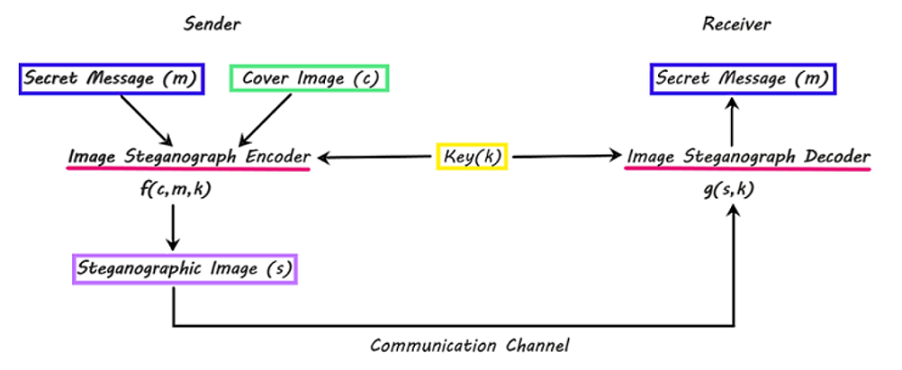

# Import Libraries 

In [ ]:
pip install pycrypto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 446 kB 7.8 MB/s 
  Created wheel for pycrypto: filename=pycrypto-2.6.1-cp37-cp37m-linux_x86_64.whl size=499932 sha256=bc9bc2dc8d38a4fde3087e68c91096b38a194a30f35d5d28fecc19487c8923c1
  Stored in directory: /root/.cache/pip/wheels/cf/85/ba/bbd7c96add459de7598fb424e5ff2309baf2095c844ac0f191
Successfully built pycrypto


In [ ]:
pip install dahuffman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scipy.fftpack import dct, idct
# from dahuffman import HuffmanCodec
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from collections import Counter
# from Crypto.Cipher import AES
import pandas as pd
import numpy as np
import base64
import random
import math
import cv2

# Load Data 

In [ ]:
hydrangea = np.array(Image.open('Hydrangea.jpg'))
silo = np.array(Image.open('Silo.jpg'))
glass = np.array(Image.open('Stained_Glass.jpg'))

# LSB - Least Significant Bit 
 LSB Steganography is a spatial domain technique in which the secret message will be embedded by altering the right most bits of the RBG pixels that make up the image data. By modifying only the least significant bits, we will achieve minimal impact on the overall appearance of the image. 
 
Spatial domain methods directly alter the pixel data to conceal the hidden message. 




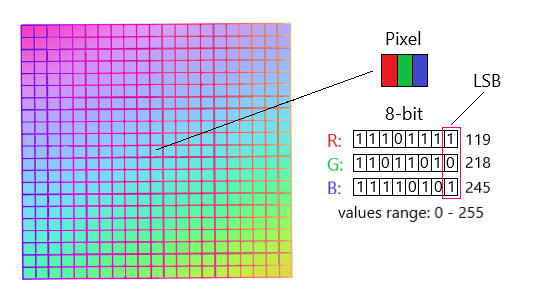

## AES Encryption based LSB Algorithm
To strengthen the security of the LSB method, AES encryption will be applied to the secret message before embedding into the image.    
A predetermined delimiter is concatenated to the secret message prior to encoding as an indication of complete message retrieval when decrypting.

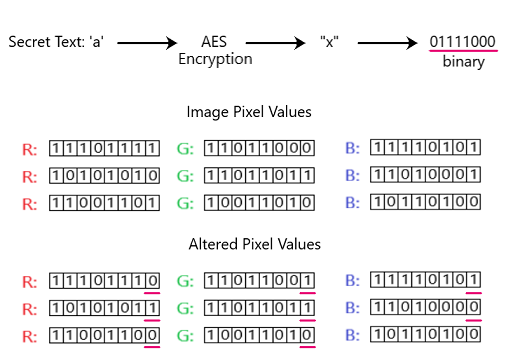

## Helper Functions

### Message To Binary

> **Input:**    
secret - Secret message String   

> **Output:**    
binarySecrets - String made up of binary representation for each character of the inputted string 

Convert secret message to binary string representation


In [ ]:
def msgToBinary(secret):
  binarySecrets = []
  for ch in secret:
    charToBinary = "{:08b}".format(ord(ch))
    binarySecrets.append(charToBinary)
  return "".join(binarySecrets)

### Binary to Message

  
> **Input:**     
binarySecrets - List of string binary representations 

> **Output:**      
secret - Secret message String

Convert list of secret binary strings to secret message 



In [ ]:
def binaryToMsg(binarySecrets):
  secret = []
  for binaryStr in binarySecrets:
    secret.append(chr(int(binaryStr, 2)))
  return "".join(secret)

## Encryption


> **Input:**     
secret - Secret message String   
cover - Image
key - String with value of 128, 192, or 256 bits of length

> **Output:**    
stegano - LSB Steganographic Image 

Embed secret key-encrypted message in the given image using the LSB method

In [ ]:
def LSB_encrypt(secret, cover, key):
  #pad key, length must be of multiples of 16
  secret += (16 - len(secret) % 16) * " "
  cipher = AES.new(bytes(key, 'utf-8'),  AES.MODE_ECB)
  encryptedMsg = base64.b64encode(cipher.encrypt(secret))

  binary = msgToBinary(encryptedMsg.decode("ascii") + "$+0p")
  # $+0p will serve as our delimiter value used in decrypting

  stegano = cover.copy()
  i, j, b = 0, 0, 0
  while(b < len(binary)):
    pixels = stegano[i][j]
    for rgb in range(0,3):
      if b < len(binary):
        msgVal = binary[b]
        binary_value = "{0:b}".format(pixels[rgb])
        changeBit = binary_value[:-1] + msgVal
        stegano[i][j][rgb] = int(changeBit, 2)
        b += 1
    i += 1
    j += 1

  return stegano

## Decryption


> **Input:**       
stegano - LSB Steganographic Image     
key - String with value of 128, 192, or 256 bits of length

> **Output:**    
secret - Secret message String  

Retrieve secret key-decrypted message in the given LSB steganograph image 

In [ ]:
def LSB_decrypt(stegano, key):
  delimiter = "$+0p"
  i, j = 0, 0
  stop = False
  curBinaryVal = []
  binarySecrets = []
  while(not stop):
    pixels = stegano[i][j]
    for value in pixels:

      if len(curBinaryVal) >= 8:
        binaryChar = "".join(curBinaryVal)
        if len(binarySecrets) >= 4 and binaryToMsg(binarySecrets[-4:]) == delimiter:
          stop = True
          binarySecrets = binarySecrets[:-4]
          break
        else:
          binarySecrets.append(binaryChar)
          curBinaryVal = []
      
      curBinaryVal.append("0" if value % 2 == 0 else "1")

    i += 1
    j += 1
  secret = binaryToMsg(binarySecrets)
  msg = base64.b64decode(bytes(secret, 'utf-8'))
  cipher = AES.new(bytes(key, 'utf-8'),  AES.MODE_ECB)
  decryptedMsg = cipher.decrypt(msg).rstrip()
  
  return decryptedMsg.decode("ascii")

## Visualization

### Image 1 - Hydrangea

Encrypt secret message in cover image 

In [ ]:
key = "0123456789012345"
secret_msg = " Fun unfortunate facts:\n Every 39 seconds there is a cyber attack\n 75% of cyber attacks start with an email\n Since COVID-19 and the increase in staff working from home\n the FBI have reported an increase of 300% in reported cybercrimes"

In [ ]:
hydrangea_LSB = LSB_encrypt(secret_msg, hydrangea, key)

Cover image and Steganographic image visual comparison

Text(0.5, 1.0, 'Steganographic Image')

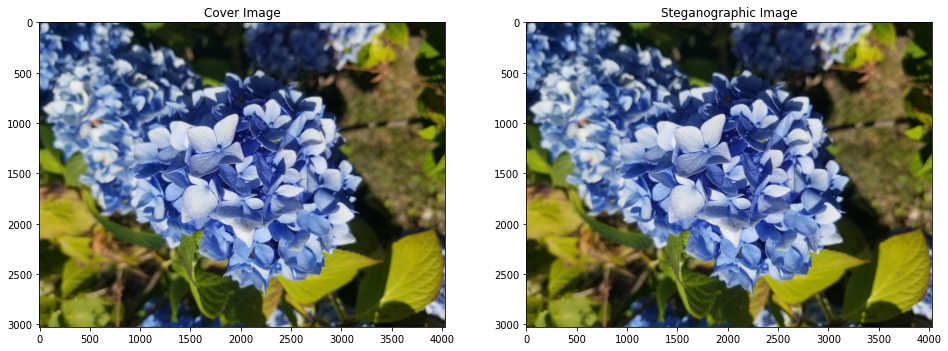

In [ ]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.imshow(hydrangea)
plt.title("Cover Image")

fig.add_subplot(1, 2, 2)
plt.imshow(hydrangea_LSB)
plt.title("Steganographic Image")

Decrypt secret message from Steganographic Image 

In [ ]:
print(LSB_decrypt(hydrangea_LSB, key))

 Fun unfortunate facts:
 Every 39 seconds there is a cyber attack
 75% of cyber attacks start with an email
 Since COVID-19 and the increase in staff working from home
 the FBI have reported an increase of 300% in reported cybercrimes


### Image 2 - Silo

Encrypt secret message in cover image 

In [ ]:
key = "AES-key-for-LSB!"
secret_msg = "The first recorded uses of steganography can be traced back to 440 BC in Greece, when Herodotus mentions an example in his Histories.\nHistiaeus sent a message to his vassal, Aristagoras, by shaving the head of his most trusted servant, marking the message onto his scalp, then sending him on his way once his hair had regrown."

In [ ]:
silo_LSB = LSB_encrypt(secret_msg, silo, key)

Cover image and Steganographic image visual comparison

Text(0.5, 1.0, 'Steganographic Image')

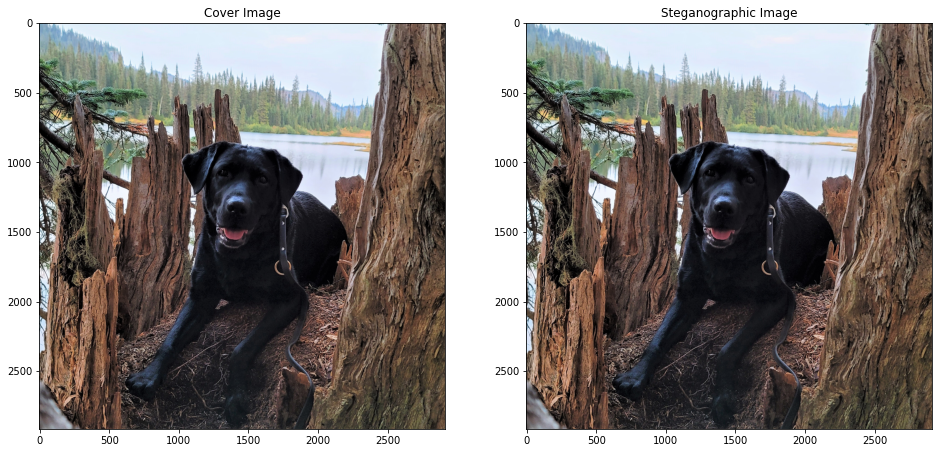

In [ ]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.imshow(silo)
plt.title("Cover Image")

fig.add_subplot(1, 2, 2)
plt.imshow(silo_LSB)
plt.title("Steganographic Image")

Decrypt secret message from Steganographic Image 

In [ ]:
print(LSB_decrypt(silo_LSB, key))

The first recorded uses of steganography can be traced back to 440 BC in Greece, when Herodotus mentions two examples in his Histories.
Histiaeus sent a message to his vassal, Aristagoras, by shaving the head of his most trusted servant, marking the message onto his scalp, then sending him on his way once his hair had regrown.


### Image 3 - Glass

Encrypt secret message in cover image 

In [ ]:
key = "Very Secret LSB Steganograph Key"
secret_msg = "The purpose of steganography is to conceal and deceive.\nIt is a form of covert communication and can involve the use of any medium to hide messages.\nIt's not a form of cryptography, because it doesn't involve scrambling data or using a key."

In [ ]:
glass_LSB = LSB_encrypt(secret_msg, glass, key)

Cover image and Steganographic image visual comparison

Text(0.5, 1.0, 'Steganographic Image')

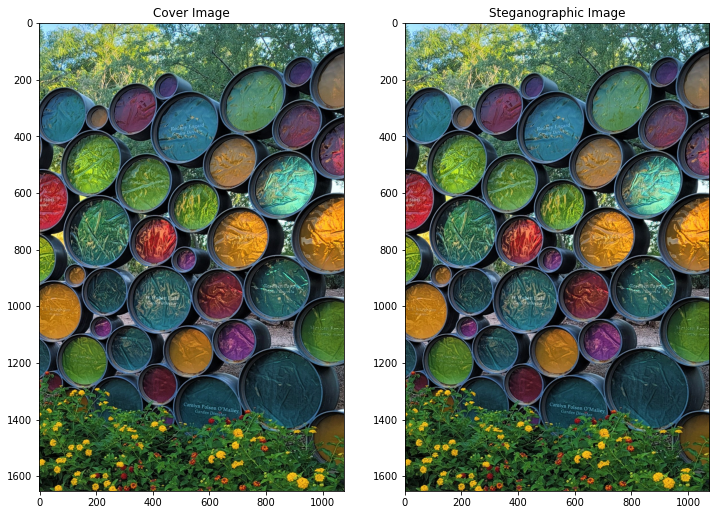

In [ ]:
fig = plt.figure(figsize=(12, 12))

fig.add_subplot(1, 2, 1)
plt.imshow(glass)
plt.title("Cover Image")

fig.add_subplot(1, 2, 2)
plt.imshow(glass_LSB)
plt.title("Steganographic Image")

Decrypt secret message from Steganographic Image 

In [ ]:
print(LSB_decrypt(glass_LSB, key))

The purpose of steganography is to conceal and deceive.
It is a form of covert communication and can involve the use of any medium to hide messages.
It's not a form of cryptography, because it doesn't involve scrambling data or using a key.


# F5
F5 Image Steganography algorithm is a transform domain technique incorporating matrix encoding of the secret message. This method follows JPEG compression techniques (DCT and Quantization) to reach the frequency domain for the encoding process. The algorithm produces a new shuffling key based off the original inputted key in which generates the pseudo-random path of the shuffled coefficients. F5 relies on shuffling to achieve Permutation Straddling which scatters the image changes of the secret message uniformly throughout. The message bits get embedded by following the matrix encoding algorithm in which results in the least changes to the non-zero DCT coefficients. F5 completes the JPEG compression step and promptly uncompresses the image to output the final steganographic image.


A transform domain method is characterized by the transformation of the spatial domain to the frequency domain used for the embedding of the hidden message before transforming back into the spatial domain. 

## Components

### YBrCr
YCbCr is a color space transformed from the RGB values with the focus on luminance and chrominance. Our eyes are sensitive to the brightness, but not so much to color. Y being the luminance component, Cb the blue-difference chrominance component, and Cr the red-difference chrominance component

The YBrCR color space is an optional step in JPEG compression process that results in a higher resolution image.


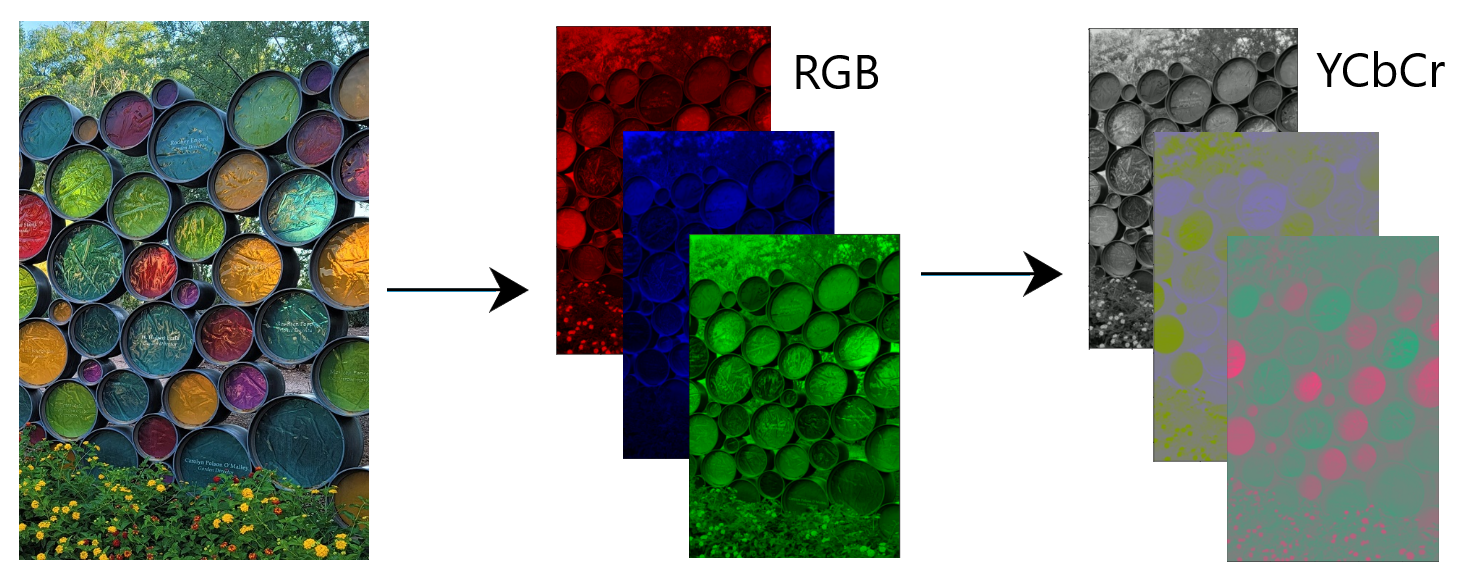


> **Input:**     
image - 3d array consisting of height, width, RGB values

> **Output:**    
Y - 2d array of the luminance component     
Cb - 2d array of the blue-difference chrominance component      
Cr - 2d array of the red-difference chrominance component

RGB to YCrBr color format transformation


In [ ]:
def RGBtoYBrCr(image):
  YCrCb = Image.fromarray(image).convert('YCbCr') 
  Y, Cb, Cr = YCrCb.split()
  return Y, Cb, Cr


> **Input:**     
Y - 2d array of the luminance component     
Cb - 2d array of the blue-difference chrominance component      
Cr - 2d array of the red-difference chrominance component

> **Output:**    
image - 3d array consisting of height, width, RGB values


YBrCr to RGB color format transformation

In [ ]:
def YBrCrToRGB(Y, Cb, Cr):
  return Image.merge('YCbCr', (Y, Cb, Cr))  

### DCT

Discrete Cosine Transformations, when applied to an image, transforms it from the spatial domain into the frequency one. This is done to reveal redundancy in the image. High frequencies are areas that tend to be convoluted that do not stand out to the eye while low frequencies are the most defined and crucial to maintaining the pictured objects.  

The DCT matrix below is a visual representation of the 64 cosine functions that at a basic level can be combined to recreate any 8 x 8 image.

After applying the DCT to the image, the result is a matrix of values where the value at position (0,0) is referred to as the DC coefficient and the most important because it is the approximation of what the eye can most see in an image. The remaining 63 values are called AC coefficients. Higher frequency components tend to reside in the lower right parts of the matrix.




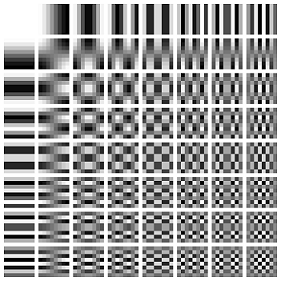

**DCT - Discrete Cosine Transform**

$$f^k(u,v) = \dfrac{1}{4}α(u)α(v)\sum\limits_{x = 0}^{7}\sum\limits_{y = 0}^{7}F^k_{x,y}cos\left[\dfrac{uπ(2x + 1 )}{16}\right]cos\left[\dfrac{vπ(2y + 1 )}{16}\right] 
$$


**DCT$^{-1}$ - Inverse Discrete Cosine Transform**

$$F^k(x,y) = \dfrac{1}{4}\sum\limits_{u = 0}^{7}\sum\limits_{v = 0}^{7}α(u)α(v)f^k_{u,v}cos\left[\dfrac{uπ(2x + 1 )}{16}\right]cos\left[\dfrac{vπ(2y + 1 )}{16}\right]  
\text{where } α(u) = \begin{cases} 
\dfrac{1}{\sqrt{8}} \text{ if } u = 0\\
 1 \text{ otherwise}
 \end{cases}$$

* _k_ denotes the kth block
*  $\alpha(u)$ denotes the normalizing scale factor to prevent shrinkage
*  _u_ denotes spatial frequency row 
*  _v_ denotes spatial frequency column 
*  _i_ denotes pixel row 
*  _j_ denotes pixel column 
*  $f^k(u,v)$ denotes the DCT coefficient 
*  $F^k(i,j)$ denotes the pixel value in the 8x8 cover image block



In [ ]:
def DCT(block): 
  pi = math.pi
  dct2 = [[0 for x in range(8)] for y in range(8)]
  for u in range(8):
      for v in range(8):
          sum = 0
          for x in range(8):
              for y in range(8):
                  dct1 = block[x][y] * math.cos((u * pi * (2 * x + 1))/16) * math.cos((v * pi * (2 * y + 1))/16)
                  sum += dct1
          alpha_u = 1 / (math.sqrt(8)) if u == 0 else 0.5
          alpha_v = 1 / (math.sqrt(8)) if v == 0 else 0.5
          dct2[u][v] = alpha_u * alpha_v * sum
  return dct2

In [ ]:
def DCTinverse(block):
  pi = math.pi
  dct2 = [[0 for x in range(8)] for y in range(8)]
  for u in range(8):
      for v in range(8):
          sum = 0
          alpha_u = 1 / (math.sqrt(8)) if u == 0 else 0.5
          alpha_v = 1 / (math.sqrt(8)) if v == 0 else 0.5
          for x in range(8):
              for y in range(8):
                  dct1 = block[x][y] * math.cos((u * pi * (2 * x + 1))/16) * math.cos((v * pi * (2 * y + 1))/16)
                  sum += alpha_u * alpha_v * dct1
          dct2[u][v] = sum
  return dct2

### Quantization Matrix


The quantization matrix when applied provides higher resolution to the more perceivable lower frequency components. The higher frequencies are less perceivable to the eye and therefore, when eliminated, do not have an impact on our perception of the overall image. 

By subjecting a DCT transformed matrix to the quantization matrix, we effectively zero out many values on the lower right portion of the image. Those are the high frequency values. This is why the JPEG compression algorithm is lossy.

For the YCbCr color scheme, the respective quantization matrix are according to luminance and chrominance components. 

For the RGB color scheme, the luminance quantization should only be used.

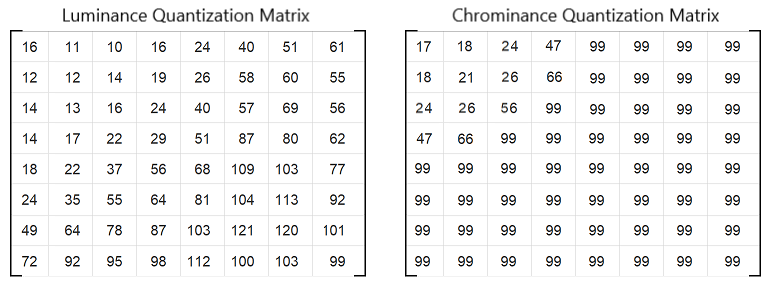

In [ ]:
Q_LUM = [[16,	11,	10,	16,	24,	40,	51,	61],
        [12,	12,	14,	19,	26,	58,	60,	55],
        [14,	13,	16,	24,	40,	57,	69,	56],
        [14,	17,	22,	29,	51,	87,	80,	62],
        [18,	22,	37,	56,	68,	109,103,77],
        [24,	35,	55,	64,	81,	104,113,92],
        [49,	64,	78,	87,	103, 121,120,101],
        [72,	92,	95,	98,	112, 100,103,99]]

In [ ]:
Q_CHR = [[17, 18, 24, 47, 99, 99, 99, 99], 
         [18, 21, 26, 66, 99, 99, 99, 99],
         [24, 26, 56, 99, 99, 99, 99, 99],
         [47, 66, 99, 99, 99, 99, 99, 99],
         [99, 99, 99, 99, 99, 99, 99, 99],
         [99, 99, 99, 99, 99, 99, 99, 99],
         [99, 99, 99, 99, 99, 99, 99, 99],
         [99, 99, 99, 99, 99, 99, 99, 99]]

### Permutative Straddling

Permutative Straddling uniformly spreads out the pixel bits that get changed through out the entire steganographic image. The positions are based off the key in which will prepare the block for the encoding algorithm. Upon completion of encoding, the block will be unshuffled to its original positions.




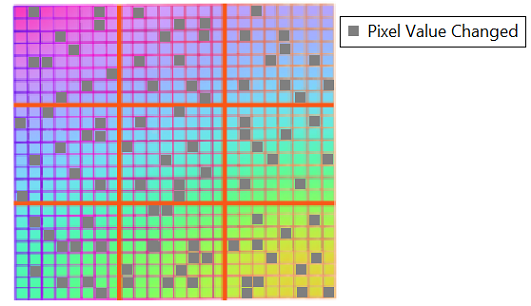


> **Input:**     
block - 8 by 8 block of DCT coefficients     
shufflingKey - list of integers from 0 to 63 representing index path

> **Output:**    
shuffledBlock - 8 by 8 block with shuffled DCT coefficients


Shuffle DCT coefficients according to the shufflingKey

In [ ]:
def permutativeStraddling(block, shufflingKey):
  block = np.array(block).flatten()
  shuffledBlock = [0] * 64
  for i in range(64):
    idx = shufflingKey[i]
    shuffledBlock[idx] = block[i]
  return np.array(shuffledBlock).reshape((8,8))


> **Input:**     
block - 8 by 8 block with shuffled DCT coefficients 
shufflingKey - list of integers from 0 to 63 representing index path

> **Output:**    
unShuffledBlock - 8 by 8 block of DCT coefficients    

UnShuffle DCT coefficients according to the shufflingKey

In [ ]:
def unShufflePermutativeStraddling(block, shufflingKey):
  block = np.array(block).flatten()
  unShuffledBlock = [0] * 64
  for i in range(64):
    idx = shufflingKey[i]
    unShuffledBlock[i] = block[idx]
  return np.array(unShuffledBlock).reshape((8,8))

### Matrix Encoding

The application of matrix encoding entails the rightmost 3-bit cells of the non-zero quantized DCT coefficients are subject to the Exclusive OR operator to determine any necessary alterations of the bits in order to produce the 2-bit secret message section. This will result in the least amount of change to the bits.

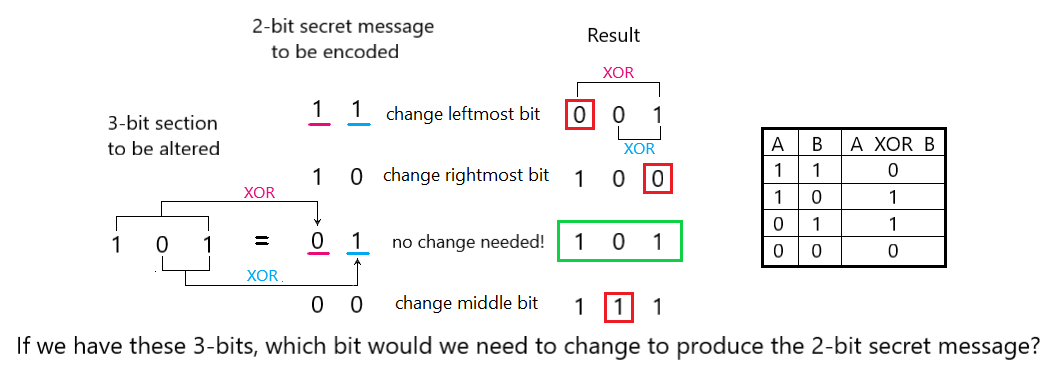

> **Input:**     
coeffCounts - Dictionary of coefficient counts  
image - Quantized image values   
messageBits - String of binary represenation of secret message

> **Output:**    
image - Image with embedded secret message

Quantized Image will undergo matrix encoding to embed secret message.


In [ ]:
#TODO: work in progress 
def matrixEncoding(coeffCounts, image, messageBits):
# parameters to determine best matrix embedding
# (coeffCounts["DCT_coeffs"]/64) removes the number of DC coeffs which is equivalent to the number of blocks - note: there is 1 DC coeff per block
# 0.51h(1) is the estimated loss due to shrinkage
  
  zeros = coeffCounts["AC_0s"]
  ones = coeffCounts["AC_abs_1s"]
  #capacity is the number of modifiable places   
  capacity = coeffCounts["DCT_coeffs"] - (coeffCounts["DCT_coeffs"]/64) - zeros - (0.51 * ones)


# Embed 31 bits of metadata (matrix encoding parameter w and message length l) into the shuffled non-zero AC coefficients.
  k = len(messageBits) 
  n = 2**k - 1

  #note: equations
  # changeDensity = 1 / 2**k
  # embeddingRate = k / n 
  # efficiencyRate = embeddingRate / changeDensity


#The message is divided into segments of k bits that are embedded into a group of 2k–1 coefficients
 
'''
  changedBits = 0
  expected = 0
  for i in range(len(1,8)):
    n = 2**i - 1
    usable = expected * i / n - expected * i / n % n

    changedBits = capacity - (capacity % (n + 1))
    changedBits = (changedBits + ones + (ones / 2) - ones / (n + 1)) / (n + 1)
    usable /= 8
    if usable == 0 :
        break
  
  
  examinedBits = 0
  idx = 0
  for i in range(len(image)):
    curCoeff = image[i]
    if i % 64 == 0 or curCoeff  == 0:
      continue
    examinedBits += 1
    
    if the cur bit is positive and odd and not == to the next message bit to embed
      cur - 1 
      chnaged + 1
    if cur is negative and odd and == to next message bit 
      cur + 1
      changed + 1
    if cur is not 0 after changes
      if avail bits == 0 
        if n > 1 or embeddedData.available == 1
          break
      avail bits to embed = 8  # ??
    else
      thrown ++    
   

   return image  
'''
   

### Zigzag travesal   

The DCT block will be subject to the zigzag traversal pattern in order to be fed into the huffman encoder. This outputs a one dimensional array that will place the non-zero coefficients ahead of most the zero coefficients.

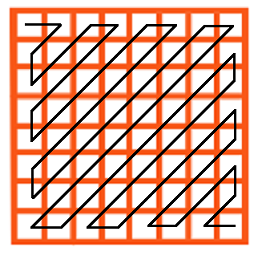


> **Input:**         
block - DCT coefficent matrix 

> **Output:**    
zigzag - Array of zigzagged ordered coefficients

The DCT coefficient blocks will be ordered in a zigzag fashion into a one dimensional array


In [ ]:
def zigzag(block):
  order = [[] for i in range(15)]
  zigzag = []
  for i in range(8):
      for j in range(8):
          sum = i + j
          if(sum % 2 == 0): # add at beginning
              order[sum].insert(0, block[i][j])
          else: # add at end of the list
              order[sum].append(block[i][j])
  for row in order:
    zigzag += row
  return np.array(zigzag)

> **Input:**         
zigzagged - Array of zigzagged ordered coefficients

> **Output:**    
block - Original DCT coefficent matrix 

The coefficients will be reordered from the zigzag one-dimensional array into the original 8 by 8 DCT coefficient block

In [ ]:
def undoZigzag(zigzagged):
  order = zigzag(np.array(list(range(64))).reshape((8,8)))
  block = [0] * 64
  for i in range(64):
    block[order[i]] = zigzagged[i]
  return np.array(block).reshape((8,8))

### Huffman Coding

A variable-length encoding algorithm that results in lossless data compression. Hufman Coding relies on the frequency of each symbol to build the code reference table used to represent chunks of the data to achieve a reduction in the total length. 





In [ ]:
def huffmanCoding(array):
  #probabilities 
  counts = Counter(array)
  probs = {k:v/64 for k,v in counts.items()}
  probs = sorted(probs.items(), key=lambda item: item[1])
  codec = HuffmanCodec.from_frequencies(dict(probs))
  # print(HuffmanCodec.print_code_table(codec))
  encoded = codec.encode(array) # compression completed
  decoded = codec.decode(encoded) #uncomress image
  return decoded

## Helper Functions

### Shuffling Key
> **Input:**         
key - String or integer value

> **Output:**    
shuffledKey - List of integers ranging from 0 to 63 inclusive

Creates a list of key-based random integers representing the index ordering to serve as the shuffling key

In [ ]:
def shufflingKey(key):
  random.seed(key)
  idx = list(range(1, 64))
  shuffledKey = [0]
  for i in range(1, 64):
    num = random.choice(idx)
    idx.remove(num)
    shuffledKey.append(num)
  return shuffledKey

### Pad Image
> **Input:**       
image - Image constructed by a 3d array

> **Output:**    
 paddedImage - Padded Image

Padding is given to an image by duplicating neighboring pixel values on the right and bottom sides of the image in order for the number of rows and columns to be truly divisable by 8

In [ ]:
def padImage(image):
  addHeight = 0 if image.shape[0] % 8 == 0 else 8 - image.shape[0] % 8 
  addWidth = 0 if image.shape[1] % 8 == 0 else 8 - image.shape[1] % 8
  if addHeight != 0:
    image = np.concatenate((image, image[-addHeight:, :]), axis=0) 
  if addWidth != 0: 
    image = np.concatenate((image, image[:,-addWidth:]), axis=1)
  return image

### Compress/Permutate

> **Input:**       
image - Image constructed by a 3d array  
shufflingKey - List of integers ranging from 0 to 63 inclusive   
Q - Corresponding Quantization matrix

> **Output:**    
image - Image altered from JPEG compression and permutative straddling    
coeffs - Dictionary of coefficient counts

JPEG Compression and Permutative Straddling applied to image

In [ ]:
def compressAndPermutate(image, shuffleKey, Q):

  # data vars for matrix encoding
  coeffCounts = {"AC_0s" : 0, "AC_abs_1s" : 0, "non-zero_coeffs" : 0, "DCT_coeffs": 0}
  height = image.shape[0]
  width = image.shape[1]
  stegano = np.zeros((height, width))
  for i in range(1, height//8 + 1):
    startRow = (i - 1) * 8
    endRow = (i * 8) 
    for j in range(1, width//8 + 1):
      startCol = (j - 1) * 8
      endCol = (j * 8) 
      block = image[startRow:endRow, startCol:endCol]

      # coeffs = DCT(block) # scipys dct is a much faster implementation
      coeffs = dct(dct(block.T, norm = 'ortho').T, norm = 'ortho')

      # numpy.divide, numpy.floor_divide, np.divide(coeffs,Q).astype(int) DO NOT produce the correct values
      quantized = [[0 for x in range(8)] for y in range(8)]
      for k in range(8):
        for l in range(8):
          qCoeff = round(coeffs[k][l] / Q[k][l])
          quantized[k][l] = qCoeff

          if qCoeff == 0:
            coeffCounts["AC_0s"] += 1
          elif abs(qCoeff) == 1:
            coeffCounts["AC_abs_1s"] += 1
          else:
            coeffCounts["non-zero_coeffs"] += 1

      coeffCounts["DCT_coeffs"] += 64
      shuffledCoeffs = permutativeStraddling(quantized, shuffleKey)
      stegano[startRow:endRow, startCol:endCol] = shuffledCoeffs
  return stegano, coeffs

## Encryption


> **Input:**     
secret - Secret message String   
cover - Image constructed by a 3d array    
key - String or integer value

> **Output:**    
stegano - F5 Steganographic Image 

Embed secret message in the given image using the F5 method

In [ ]:
def F5_encrypt(secret, cover, key):
  shuffleKey = shufflingKey(key)
  secret =  msgToBinary(secret)

  coeffCountLists = []
  compressResults = []

  Y, Cb, Cr = RGBtoYBrCr(cover)
 
  isY = True
  Q = Q_LUM
  for image in [Y, Cb, Cr]:
    # center values around 0 for DCT since it applies Cosine to the image
    image = np.array(image)#- 128
    if not isY:
      Q = Q_CHR
      # subsampling for chrominance channels - sampling 
      chrom = cv2.boxFilter(image, ddepth=-1, ksize=(2, 2))
      image = chrom[::2, ::2]
    isY = False 
    image = padImage(image) 
    stegano, coeffCounts = compressAndPermutate(image, shuffleKey, Q)
    coeffCountLists.append(coeffCounts)
    compressResults.append(stegano)

  
  # Matrix encoding - Work in progress # 
  # compressResults[0] = matrixEncoding(coeffCounts, compressResults[0], secret)
  ####

  uncompressResults = []
  Q = Q_LUM
  isY = True

  
  for image in compressResults:
    if not isY:
      Q = Q_CHR

    height = image.shape[0]
    width = image.shape[1]
    stegano = np.zeros((height, width))
    for i in range(1, height//8 + 1):
      startRow = (i - 1) * 8
      endRow = (i * 8) 
      for j in range(1,width //8 + 1):
        startCol = (j - 1) * 8
        endCol = (j * 8) 

        block = image[startRow:endRow, startCol:endCol]
        unShuffledCoeffs = unShufflePermutativeStraddling(block, shuffleKey)
     
        zigzagged = zigzag(unShuffledCoeffs)
        huffman = huffmanCoding(zigzagged)  
        unZigzag = undoZigzag(huffman)
       
        dequantized = np.multiply(unZigzag , Q)

        #### current dct inverse function contains miscalculations,  calculate iDCT with scipy idct
        # iDCT = DCTinverse(quantized)
        iDCT = idct(idct(dequantized.T, norm = 'ortho').T, norm = 'ortho')
        stegano[startRow:endRow, startCol:endCol] = np.round(iDCT)
 
        
    isY = False   
    stegano = np.clip(stegano, 0, 255)
    uncompressResults.append(np.uint8(stegano))

  #resize subsampling 
  Y = uncompressResults[0]
  height = Y.shape[0]
  width = Y.shape[1]

  Y = Image.fromarray(Y)

  Cb = cv2.resize(uncompressResults[1],(width, height))
  Cr = cv2.resize(uncompressResults[2],(width, height))

  
  return YBrCrToRGB(Y, Image.fromarray(Cb), Image.fromarray(Cr))

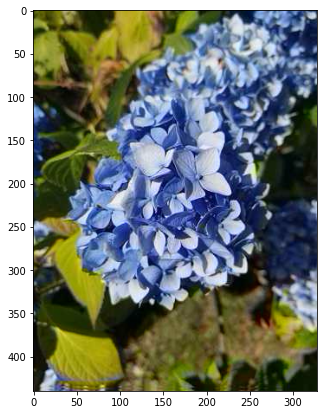

In [ ]:
#Testing to confirm the JPEG compress /uncompress is functional
t = np.array(Image.open('t.jpg'))
t_F5 = F5_encrypt("", t,"")
fig = plt.figure(figsize=(7, 7))
plt.imshow(t_F5)

## Decryption


> **Input:**       
stegano - F5 Steganographic Image     
key - String or integer value

> **Output:**    
secret - Secret message String

Retrieve secret message in the given F5 Steganograph image 

In [ ]:
def F5_decrypt(stegano, key):
  shuffleKey = shufflingKey(key)

  coeffCountLists = []
  compressResults = []

  Y, Cb, Cr = RGBtoYBrCr(stegano)
  isY = True
  Q = Q_LUM
  for image in [Y, Cb, Cr]:
    # center values around 0 for DCT since it applies Cosine to the image
    image = np.array(image) - 128
    if not isY:
      Q = Q_CHR
      # subsampling for chrominance channels - sampling 
      chrom = cv2.boxFilter(image, ddepth=-1, ksize=(2, 2))
      image = chrom[::2, ::2]
    image = padImage(image) 
    stegano, coeffCounts = compressAndPermutate(image, shuffleKey, Q)
    coeffCountLists.append(coeffCounts)
    compressResults.append(stegano)
    isY = False 

  #TODO:
    # Extract message length
    # Extract message from matrix decoding 

## Visualization

### Image 1 - Hydrangea

Encrypt secret message in cover image 

In [ ]:
key = "0123456789012345"
secret_msg = " Fun unfortunate facts:\n Every 39 seconds there is a cyber attack\n 75% of cyber attacks start with an email\n Since COVID-19 and the increase in staff working from home\n the FBI have reported an increase of 300% in reported cybercrimes"

In [ ]:
hydrangea_F5 = F5_encrypt(secret_msg, hydrangea, key)

Cover image and Steganographic image visual comparison

In [ ]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.imshow(hydrangea)
plt.title("Cover Image")

fig.add_subplot(1, 2, 2)
plt.imshow(hydrangea_F5)
plt.title("Steganographic Image")

Decrypt secret message from Steganographic Image 

In [ ]:
print(F5_decrypt(hydrangea_F5, key))

### Image 2 - Silo

Encrypt secret message in cover image 

In [ ]:
key = "AES-key-for-LSB!"
secret_msg = "The first recorded uses of steganography can be traced back to 440 BC in Greece, when Herodotus mentions an example in his Histories.\nHistiaeus sent a message to his vassal, Aristagoras, by shaving the head of his most trusted servant, marking the message onto his scalp, then sending him on his way once his hair had regrown."

In [ ]:
silo_F5 = F5_encrypt(secret_msg, silo, key)

Cover image and Steganographic image visual comparison

In [ ]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.imshow(silo)
plt.title("Cover Image")

fig.add_subplot(1, 2, 2)
plt.imshow(silo_F5)
plt.title("Steganographic Image")

Decrypt secret message from Steganographic Image 

In [ ]:
print(F5_decrypt(silo_F5, key))

### Image 3 - Glass

Encrypt secret message in cover image 

In [ ]:
key = "Very Secret LSB Steganograph Key"
secret_msg = "The purpose of steganography is to conceal and deceive.\nIt is a form of covert communication and can involve the use of any medium to hide messages.\nIt's not a form of cryptography, because it doesn't involve scrambling data or using a key."

In [ ]:
glass_F5 = F5_encrypt(secret_msg, glass, key)

Cover image and Steganographic image visual comparison

In [ ]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.imshow(glass)
plt.title("Cover Image")

fig.add_subplot(1, 2, 2)
plt.imshow(glass_F5)
plt.title("Steganographic Image")

Decrypt secret message from Steganographic Image 

In [ ]:
print(F5_decrypt(glass_F5, key))

# Metrics 

## MSE - Mean Square Error
The average squared difference between original image and altered steganographic image.

**Goal:** lower MSE indicates lower error between hidden image and cover image.

$$MSE = \dfrac{1}{mn}\sum\limits_{i = 0}^{m-1}\sum\limits_{j = 0}^{n-1}\left[C(i,j)-S(i,j)\right]^2$$

*  _m_ denotes image rows
*  _n_ denotes image columns
*  _C(i,j)_ denotes pixel value of original cover image
*  _S(i,j)_ denotes pixel value of steganographic image 



In [ ]:
def MSE(cover, stegano):
  MSE = np.square((cover - stegano)).mean()
  return MSE 

##  PSNR - Peak Signal to Noise Ratio 
The ratio between maximum power of a signal and the power of corrupting noise regarding the quality of the compressed steganographic image compared to the origial.

**Goal:** high PSNR value indicates greater similarities of the steganographic image compared to the original. Imperceptibilty is achieve if PSNR is above 36 dB.

$$PSNR = 20\log_{10}\left(\dfrac{MAX_c} {\sqrt{MSE}}\right)$$

*  $MAX_c$ denotes maximum possible pixel value of the original cover image
*   _MSE_ denotes Mean Square Error




In [ ]:
def PSNR(MSE):
  if MSE == 0:
    #There is no noise 
    return 100
  PSNR = 20 * math.log10(255 / math.sqrt(MSE))
  return PSNR 

## NCC - Normalized Cost Correlation 
Evaluates degree of closeness between the cover image and steganographic image.

**Goal:** A value closer to 1 indicates the images higher similarity.

$$NCC = \dfrac{\sum\limits_{i = 1}^{m}\sum\limits_{j = 1}^{n}C(i,j)* S(i,j)}{\sum\limits_{i = 1}^{m}\sum\limits_{j = 1}^{n}C(i,j)^2}$$

*  _m_ denotes image rows
*  _n_ denotes image columns
*  _C(i,j)_ denotes pixel value of original image
*  _S(i,j)_ denotes pixel value of steganographic image 


In [ ]:
def NCC(cover, stegano):
  NCC = (cover * stegano).sum() / np.square(cover).sum()
  return NCC

## SSIM - Structured Similarity Index Measure
Evaluates level of structural simiarity between cover image and steganpgraphic image. 

**Goal:** greater values closer to 1 represent higher similarities.

$$SSIM = \dfrac{(2μ_cμ_s + c_1)(2σ_{cs}+c_2)}{(μ_c^2μ_s^2 + c_1)(σ_c^2+σ_s^2+c_2)}$$


* c denotes the cover image
* s denotes the steganographic image
*   μ denotes pixel sample mean of c, s respectively 
*   σ denotes the variance of c, s respectively
* $σ_{cs}$ denotes the covariance of c and s
* $σ^2$ denotes the mean variance of c, s respectively 
* $c_1, c_2$ denotes varibales to stabilize division in weak denominator events




In [ ]:
def SSIM(cover, stegano):
  c_mu = cover.mean()
  s_mu = stegano.mean()
  c_var = np.square(np.var(cover))
  s_var = np.square(np.var(stegano))
  cs_covar = np.sum(((cover - c_mu) * (stegano - s_mu)) / (len(cover) - 1))
  c1 = (0.01 * 255)**2
  c2 = (0.03 * 255)**2
  numerator = (2 * c_mu * s_mu + c1) * (2 *cs_covar + c2 )
  denominator = ((np.square(c_mu) * np.square(s_mu)) + c1)  * (c_var + s_var + c2)
  SSIM = numerator / denominator
  return SSIM

## Evaluation

### LSB

In [ ]:
data = {"Image" : ["Hydrangea", "Silo", "Glass"], "MSE" : [],"PSNR"  : [], "NCC" : [], "SSIM" : []}

In [ ]:
MSE_LSB = MSE(hydrangea, hydrangea_LSB)
data["MSE"].append(MSE_LSB)
data["PSNR"].append(PSNR(MSE_LSB))
data["NCC"].append(NCC(hydrangea, hydrangea_LSB))
data["SSIM"].append(SSIM(hydrangea, hydrangea_LSB))

In [ ]:
MSE_LSB = MSE(silo, silo_LSB)
data["MSE"].append(MSE_LSB)
data["PSNR"].append(PSNR(MSE_LSB))
data["NCC"].append(NCC(silo, silo_LSB))
data["SSIM"].append(SSIM(silo, silo_LSB))

In [ ]:
MSE_LSB = MSE(glass, glass_LSB)
data["MSE"].append(MSE_LSB)
data["PSNR"].append(PSNR(MSE_LSB))
data["NCC"].append(NCC(glass, glass_LSB))
data["SSIM"].append(SSIM(glass, glass_LSB))

In [ ]:
pd.DataFrame(data)

,Image,MSE,PSNR,NCC,SSIM
0,Hydrangea,0.000036,92.544159,1.000008,0.000557
1,Silo,0.000071,92.544159,1.000019,0.000348
2,Glass,0.000270,92.544159,1.000051,0.000356


### F5

# References

A. Soria-Lorente, S. Berres, "A Secure Steganographic Algorithm Based on Frequency Domain for the Transmission of Hidden Information", Security and Communication Networks, vol. 2017, Article ID 5397082, 14 pages, 2017. https://doi.org/10.1155/2017/5397082 

Amarendra, K. et al. “Image Steganography Using LSB.” International Journal of Scientific & Technology Research 8 (2019): 906-909.


Dhuriya, Ankur. “What Are DCT Coefficients and How JPEG Compression Works?” Medium, Analytics Vidhya, 1 July 2020, https://medium.com/analytics-vidhya/what-are-dct-coefficients-and-how-jpeg-compression-works-7f46d1e22b4c. 

Fridrich, Jessica, et al. “Steganalysis of JPEG Images: Breaking the F5 Algorithm.” Information Hiding, 2002, pp. 310–323., https://doi.org/10.1007/3-540-36415-3_20. 

Guzman, Anthony Rene (2022): Image Steganography Using Deep Learning Techniques. Purdue University Graduate School. Thesis. https://doi.org/10.25394/PGS.19666473.v1 

Hashim, Mohammed Mahdi et al. “Performance evaluation measurement of image steganography techniques with analysis of LSB based on variation image formats.” (2018).

Jain, Devang. “LSB Image Steganography Using Python.” Medium, The Startup, 8 Apr. 2021, https://medium.com/swlh/lsb-image-steganography-using-python-2bbbee2c69a2. 

“JPEG: Colorspace Transform, Subsampling, DCT and Quantisation¶.” Jpeg: Colorspace Transform, Subsampling, DCT and Quantisation - Multimedia Codec Excercises 1.0 Documentation, https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/jpegUpToQuant.html. 

  Liu, Jianyi, et al. “A Controllable Image Steganography with Chaos and User Key.” Image and Graphics, Springer International Publishing, 2021, pp. 785–97, https://doi.org/10.1007/978-3-030-87355-4_65.

Liu, J., Yang, C., Wang, J. et al. Stego key recovery method for F5 steganography with matrix encoding. J Image Video Proc. 2020, 40 (2020). https://doi.org/10.1186/s13640-020-00526-2

Reyes, Sh. “Performance Metrics for Image Steganography.” GeeksforGeeks, 28 Oct. 2021, https://www.geeksforgeeks.org/performance-metrics-for-image-steganography/. 

Verdier, Varden. “Discrete Cosine Transform.” SlideServe, 13 July 2014, https://www.slideserve.com/varden/discrete-cosine-transform. 

Wang, J., Yang, C., Zhu, M. et al. JPEG image steganography payload location based on optimal estimation of cover co-frequency sub-image. J Image Video Proc. 2021, 1 (2021). https://doi.org/10.1186/s13640-020-00542-2

Westfeld, Andreas. “F5—A Steganographic Algorithm: High Capacity Despite Better Steganalysis.” Information Hiding, Springer Berlin Heidelberg, 2001, pp. 289–302, https://doi.org/10.1007/3-540-45496-9_21.

